In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import re

from keras.utils import to_categorical
from keras.optimizers import Adam

import tensorflow as tf

import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel

import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\mario\anaconda3\envs\CAPSTONE_PROJECT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv('../../Datasets/GoEmotions/go_emotions_dataset.csv')

In [4]:
df.columns

Index(['id', 'text', 'example_very_unclear', 'admiration', 'amusement',
       'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
       'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral'],
      dtype='object')

In [5]:
objectives = ['text', 'fear', 'surprise', 'anger', 'joy', 'sadness', 'neutral']
new_df = df[objectives]

#0 sadness, 1 joy, 2 anger, 3 fear, 4 surprise, 5 neutral
sadness_df = new_df[new_df.sadness==1]
sadness_df['label'] = 0
sadness_df = sadness_df[['text','label']]

joy_df = new_df[new_df.joy==1]
joy_df['label'] = 1
joy_df = joy_df[['text','label']]

anger_df = new_df[new_df.anger==1]
anger_df['label'] = 2
anger_df = anger_df[['text','label']]

fear_df = new_df[new_df['fear']==1]
fear_df['label'] = 3
fear_df = fear_df[['text','label']]

surprise_df = new_df[new_df.surprise==1]
surprise_df['label'] = 4
surprise_df = surprise_df[['text','label']]

neutral_df = new_df[new_df.neutral==1]
neutral_df['label'] = 5
neutral_df = neutral_df[['text','label']]

all_dfA = pd.concat((fear_df, surprise_df, anger_df, joy_df, sadness_df, neutral_df))

C:\Users\mario\AppData\Local\Temp\ipykernel_28084\2385767688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sadness_df['label'] = 0
C:\Users\mario\AppData\Local\Temp\ipykernel_28084\2385767688.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joy_df['label'] = 1
C:\Users\mario\AppData\Local\Temp\ipykernel_28084\2385767688.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [6]:
dataset_a = all_dfA.label.value_counts().sort_index()

MIXING DATASETS

In [7]:
def clean_love(raw_train):
   raw_train = raw_train[raw_train.label != 2]
   raw_train.label = raw_train.label.apply(lambda x: x-1 if(x>2)else x)
   return raw_train 
   
raw_train = pd.read_csv("../../Datasets/text/training.csv")
raw_test = pd.read_csv("../../Datasets/text/test.csv")
raw_val = pd.read_csv("../../Datasets/text/validation.csv")

raw_train = clean_love(raw_train)
raw_test = clean_love(raw_test)
raw_val = clean_love(raw_val)

all_dfB = pd.concat((raw_train, raw_test, raw_val))

dataset_b = ((raw_train.label.value_counts() + raw_test.label.value_counts() + raw_val.label.value_counts()).sort_index())
#0 sadness, 1 joy, 2 anger, 3 fear, 4 surprise, 5 neutral

X_train = raw_train['text'].to_numpy()
y_train = raw_train['label']

X_test = raw_test['text'].to_numpy()
y_test = raw_test['label']

X_val = raw_val['text'].to_numpy()
y_val = raw_val['label']

print(f"We have {X_train.shape[0]} for training, {X_test.shape[0]} for testing and {X_val.shape[0]} for validation")
X_train = raw_train['text'].to_list()
X_test = raw_test['text'].to_list()
X_val = raw_val['text'].to_list()



global_df = pd.concat((all_dfA, all_dfB))


We have 14696 for training, 1841 for testing and 1822 for validation


C:\Users\mario\AppData\Local\Temp\ipykernel_28084\165555774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_train.label = raw_train.label.apply(lambda x: x-1 if(x>2)else x)


In [8]:
def clean_dataframe(df, threshold):
    aux1 = []
    counter = 0
    for section in df.label.value_counts().sort_index():
        if (section > threshold):
            if counter == 0 :
                aux1 = df[df.label==counter].iloc[:threshold]
                # print(aux1)
            else: 
                aux1 = pd.concat((aux1, df[df.label==counter].iloc[:threshold]), axis=0)
                # print(counter)
        else:
            if counter == 0 :
                aux1 = df[df.label==counter]
            else: 
                aux1 = pd.concat((aux1, df[df.label==counter]))
        counter = counter + 1
    return aux1

In [9]:
global_df = clean_dataframe(global_df, 10000)
X_train, X_test, y_train, y_test = train_test_split(global_df.text, global_df.label, test_size=0.22, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=123)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()

In [10]:
#Functions gonna be using
def long_sentences(X):
    b = 0
    for i in X:
        a = len(i.split(' '))
        if a > b: 
            b = a
    return b



In [11]:
#Global variables 
CATEGORIES = "sadness,joy,anger,fear,surprise,neutral".split(',')
NUM_LABELS = len(CATEGORIES)

MAX_SEQUENCE_LENGTH = max([long_sentences(X_train), long_sentences(X_val), long_sentences(X_test)])

MODEL_NAME = 'distilbert-base-uncased'
MODEL_DIRECTORY = '../model/model'
LOG_DIRECTORY = '../model/log'
MODEL_FILE = "Sentiment_detection"

FREEZE_BASE_MODEL = True

# Flag to add Dense(softmax) on top
USE_SOFTMAX_LAYER = True

# Flag to add custom classification layers on top of the base
USE_CLASSIFICATION_LAYER = False
if USE_CLASSIFICATION_LAYER == False:
    # Base needs to be trainable with no classification head
    FREEZE_BASE_MODEL = False

    # Base model only generates logits. Hence without classification layer
    # the base output needs to go through a Dense layer to reduce the output 
    # to NUM_LABELS classes. It is an option not to use softmax in the last 
    # Dense layer and feed logits into the loss function.
    USE_SOFTMAX_LAYER = True

# Normalized output into the loss layer without softmax
LOGITS_TO_LOSS = False if USE_SOFTMAX_LAYER else True

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):

    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

def decode(tokens):
    return tokenizer.decode(tokens)

In [13]:
base = TFDistilBertModel.from_pretrained(
    MODEL_NAME
)

base.summary()


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [14]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-2 if FREEZE_BASE_MODEL else 2e-5
L2 = 1e-3
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3

In [15]:
sample_tokens = tokenize(
    [   # Two example seenteces
        "i say hello", 
        "you say good bye",
    ],
    padding='longest'
)

test_tokens = tokenize([
    "i am a cat who has no name.",
    "to be or not to be."
])
TEST_BATCH_SIZE = len(test_tokens)

base_model_output = base(sample_tokens)


In [16]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
NUM_BASE_MODEL_OUTPUT = base_model_output.last_hidden_state.shape[-1]


In [17]:
output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]


In [18]:
if USE_CLASSIFICATION_LAYER:
    # -------------------------------------------------------------------------------
    # Classifiation leayer 01
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dropout(
        rate=0.15,
        name="01_dropout",
    )(output)
    
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="01_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="01_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="01_relu"
    )(output)

    # --------------------------------------------------------------------------------
    # Classifiation leayer 02
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="02_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="02_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="02_relu"
    )(output)

In [19]:
if USE_SOFTMAX_LAYER:
    LIGITS_TO_LOSS = False
    output = tf.keras.layers.Dense(
        units=NUM_LABELS,
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
        activation='softmax',
        name="softmax"
    )(output)

In [20]:
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name="name")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=LIGITS_TO_LOSS),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
assert model(test_tokens).shape == (TEST_BATCH_SIZE, NUM_LABELS)
model.summary()

Model: "name"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 66)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 66)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 66, 768),                                                    
                                 hidden_states=None                                            

In [21]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    expand_nested=True, 
    show_dtype=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    This is only for directly working on the Huggingface models.

    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    """
    def __init__(self, runner, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        # TODO: 
        #   save_pretrained() method is in the HuggingFace model only.
        #   Need to update for custom model saving.
        self.model.save_pretrained(self.output_dir)

class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )

class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: 
        Did not work with the HuggingFace native model with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable.
        
        Did not work with the tf.keras.models.save_model nor model.save()
        as causing out-of-index errors or load_model() failures. Hence use
        save_weights_only=True.
    """
    def __init__(self, path_to_file):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True,
            save_weights_only=True,  # Cannot save entire model.
            save_freq="epoch",
            verbose=1
        )

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor="val_loss",
            factor=0.3,
            patience=patience,
            verbose=1
        )

In [23]:
def to_tensor(data, label = []):
    return tf.data.Dataset.from_tensor_slices((
    dict(tokenize(data)),  # Convert BatchEncoding instance to dictionary
    label
    )).batch(BATCH_SIZE).prefetch(1)


In [24]:
Train_Dataset = to_tensor(X_train, y_train)
Val_Dataset = to_tensor(X_val, y_val)
Test_Dataset = to_tensor(X_test, y_test)

In [25]:
print("""
MAX_SEQUENCE_LENGTH = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
L2 = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
MODEL_DIRECTORY = {}
LOG_DIRECTORY = {}
""".format(
    MAX_SEQUENCE_LENGTH,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    L2,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE,
    MODEL_DIRECTORY,
    LOG_DIRECTORY
))


MAX_SEQUENCE_LENGTH = 66
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 2e-05
L2 = 0.001
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = ../model/model
LOG_DIRECTORY = ../model/log



In [26]:
history = model.fit(
    x=Train_Dataset,    # dictionary 
    # y=Y,
    y=None,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=Val_Dataset,
    callbacks=[
        EarlyStoppingCallback(patience=EARLY_STOP_PATIENCE),
        ReduceLRCallback(patience=REDUCE_LR_PATIENCE),
        ModelCheckpointCallback(MODEL_FILE),
        TensorBoardCallback(LOG_DIRECTORY)
    ]
)

Epoch 1/10
1124/1124 [==============================] - ETA: 0s - loss: 0.9515 - accuracy: 0.6604
Epoch 1: val_loss improved from inf to 0.82026, saving model to Sentiment_detection
1124/1124 [==============================] - 399s 345ms/step - loss: 0.9515 - accuracy: 0.6604 - val_loss: 0.8203 - val_accuracy: 0.7240 - lr: 2.0000e-05
Epoch 2/10
1124/1124 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.7479
Epoch 2: val_loss improved from 0.82026 to 0.78847, saving model to Sentiment_detection
1124/1124 [==============================] - 382s 340ms/step - loss: 0.7234 - accuracy: 0.7479 - val_loss: 0.7885 - val_accuracy: 0.7273 - lr: 2.0000e-05
Epoch 3/10
1124/1124 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.7871
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_loss did not improve from 0.78847
1124/1124 [==============================] - 380s 338ms/step - loss: 0.6061 - accuracy: 0.7871 - val_l

C:\Users\mario\AppData\Local\Temp\ipykernel_28084\2237750718.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['loss'], 'b', label='Training loss', color='blue', linewidth=1, linestyle='solid', marker='o', markersize=3)


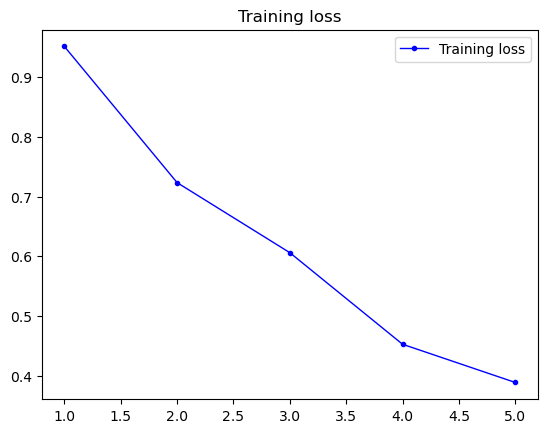

C:\Users\mario\AppData\Local\Temp\ipykernel_28084\2237750718.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy', color='blue', linewidth=1, linestyle='solid', marker='o', markersize=3)


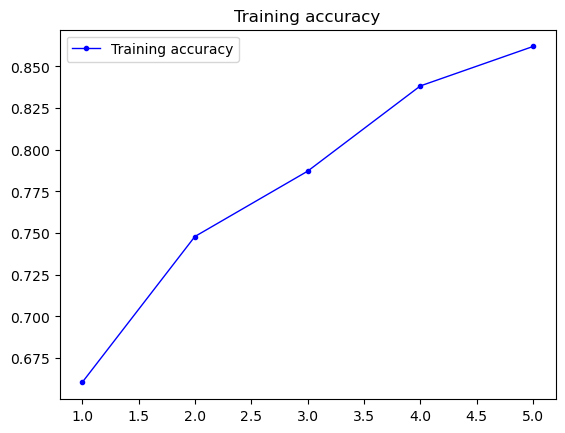

In [40]:

#change this code to make the x values only be integers
epochs = range(1, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='Training loss', color='blue', linewidth=1, linestyle='solid', marker='o', markersize=3)
plt.legend()
plt.title('Training loss')
plt.show()

plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy', color='blue', linewidth=1, linestyle='solid', marker='o', markersize=3)
plt.legend()
plt.title('Training accuracy')
plt.show()


In [27]:
def predict(str,model):
    str = to_tensor(str)
    model.predict(str)

In [38]:
model.evaluate(Test_Dataset)

357/357 [==============================] - 41s 112ms/step - loss: 0.8200 - accuracy: 0.7205


[0.8199912905693054, 0.720540463924408]

In [41]:
predict = tf.data.Dataset.from_tensor_slices((
    dict(tokenize("I love you")),
)).batch(BATCH_SIZE).prefetch(1)

In [42]:
predict = model.predict(predict)

1/1 [==============================] - 0s 355ms/step


In [31]:
def predice(array,model):
    array = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(array)),
    )).batch(BATCH_SIZE).prefetch(1)
    return pd.DataFrame(columns=CATEGORIES,data=model.predict(array))
    

In [43]:
model.save("../AnalisisSentimental", save_format='tf')

KeyboardInterrupt: 

In [44]:
predice("I didnt expect you where here",model)

1/1 [==============================] - 0s 357ms/step


,sadness,joy,anger,fear,surprise,neutral
0,0.008429,0.002522,0.003768,0.009356,0.917335,0.05859


In [34]:
model.save('SentimentAnalysis.hdf5')

In [35]:
new_model = tf.keras.models.load_model('SentimentAnalysis.hdf5', custom_objects={'TFDistilBertModel': TFDistilBertModel})

In [36]:
!pip install git+https://github.com/openai/whisper.git 

  Cloning https://github.com/openai/whisper.git to c:\users\mario\appdata\local\temp\pip-req-build-qpdp_cwj
  Resolved https://github.com/openai/whisper.git to commit 0b5dcfdef7ec04250b76e13f1630e32b0935ce76
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\mario\AppData\Local\Temp\pip-req-build-qpdp_cwj'
